# Load e imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

In [3]:
df['result'].value_counts()

result
0    483769
1    158536
Name: count, dtype: int64

# Avaliando modelo por liga

## Preprocessamento

In [4]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

## Treinamento

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)

    # model_randomf = RandomForestClassifier(n_estimators=200)
    
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

Treinando modelo para a liga: South America - Copa Libertadores
Média AUC para South America - Copa Libertadores: 0.5151461730955136
Média Acurácia para South America - Copa Libertadores: 0.7356125356125356
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3121
           1       0.92      0.15      0.26      1091

    accuracy                           0.78      4212
   macro avg       0.85      0.57      0.56      4212
weighted avg       0.81      0.78      0.71      4212


Treinando modelo para a liga: Asia - AFC Champions League
Média AUC para Asia - AFC Champions League: 0.434814930793737
Média Acurácia para Asia - AFC Champions League: 0.7214035087719298
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2534
           1       0.96      0.18      0.30       886

    accuracy                           0.78      3420
   macro avg       0.87      0.59      0.59      3420
weigh

## Avaliando importancia das features de cada liga

In [6]:
# # Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
# feature_names = X.columns

# # Loop para criar um gráfico para cada liga
# for league, data in league_histories.items():
#     # Ordenar as características e suas importâncias
#     sorted_idx = np.argsort(data['feature_importance'])
#     sorted_feature_names = feature_names[sorted_idx]
#     sorted_importances = data['feature_importance'][sorted_idx]

#     # Criando o gráfico
#     plt.figure(figsize=(10, 8))
#     plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
#     plt.title(f'Feature Importance for {league}')
#     plt.xlabel('Importance')
#     plt.ylabel('Features')
#     plt.show()


In [7]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
# dataframe_league.to_csv('dataframe_leagues_avaliation_before_f_engineering.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.735613,0.936625,0.894481,"[0.08893883462762994, 0.03302875945137768, 0.0..."
Asia - AFC Champions League,0.721404,0.956268,0.916601,"[0.08726891577017938, 0.031952044478811815, 0...."
Brazil - Paulista A1,0.780153,0.968546,0.938147,"[0.0809379596443272, 0.027765117319076146, 0.0..."
South America - Copa Sudamericana,0.762235,0.975083,0.943868,"[0.07565881578643685, 0.03153955265832636, 0.0..."
Japan - J-League,0.747388,0.926164,0.895121,"[0.08692698769905005, 0.02914684279879606, 0.0..."
USA - Major League Soccer,0.726980,0.877488,0.830644,"[0.10108701931767167, 0.03821332773669983, 0.0..."
Mexico - Liga MX,0.747160,0.931669,0.891086,"[0.08348953708456, 0.02648579934525074, 0.0275..."
Scotland - Premiership,0.746147,0.962666,0.917950,"[0.08186721688314239, 0.03274703886270576, 0.0..."
Brazil - Serie A,0.770733,0.907127,0.871975,"[0.09227965883348394, 0.023393531790194655, 0...."
France - Ligue 1,0.731063,0.944477,0.914457,"[0.0793381603797684, 0.02820388928642316, 0.01..."


In [8]:
# Calculando a média da importância de cada característica em todas as ligas
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# Convertendo a lista de importâncias das características em um DataFrame para facilitar a análise
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculando a variância da importância de cada característica em todas as ligas
feature_variances = df_feature_importances.var()

# Criando um DataFrame resumo para conter os dados de variância e correlação
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Exibindo o DataFrame resumo ordenado por variância para ver quais características têm mais variabilidade entre as ligas
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns
# feature_names = df.drop(['result', 'league'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])

summary_df.sort_values('Mean Importance', ascending=False)


,Feature,Mean Importance,Variance,Feature Name
0,0,0.082135,0.000050,minute
7,24,0.060155,0.000027,possessiontime_home
8,23,0.059573,0.000025,possessiontime_away
16,21,0.057131,0.000020,tackles_home
13,22,0.056336,0.000021,tackles_away
1,3,0.055761,0.000049,shotsHome
10,17,0.053753,0.000024,fouls_home
15,18,0.052410,0.000021,fouls_away
11,4,0.049216,0.000024,shotsAway
5,11,0.043591,0.000035,shotsOffgoal_home


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

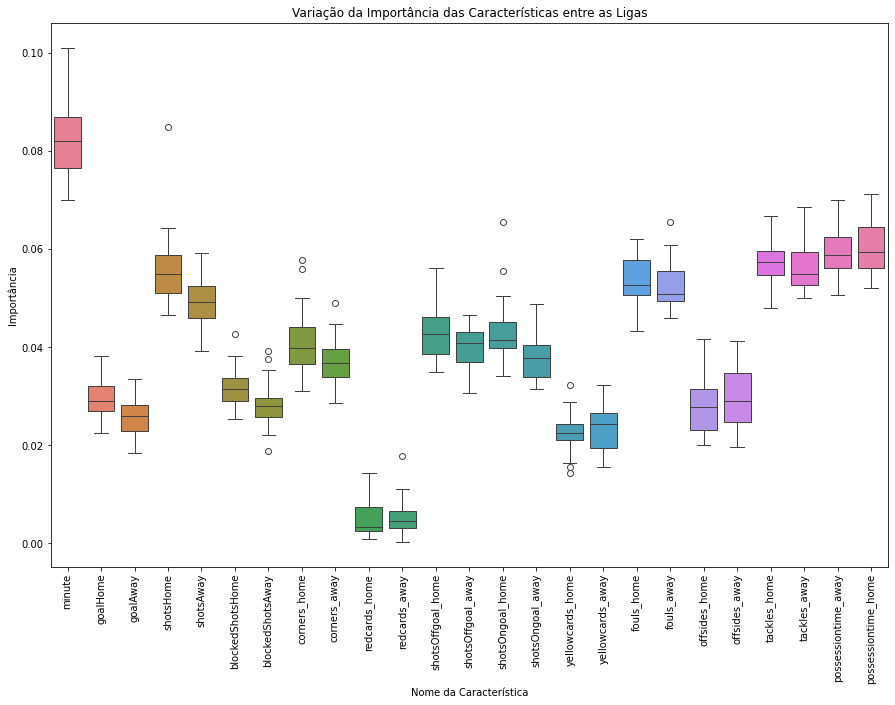

In [9]:
# Conversão do que ta no dataframe para lista
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

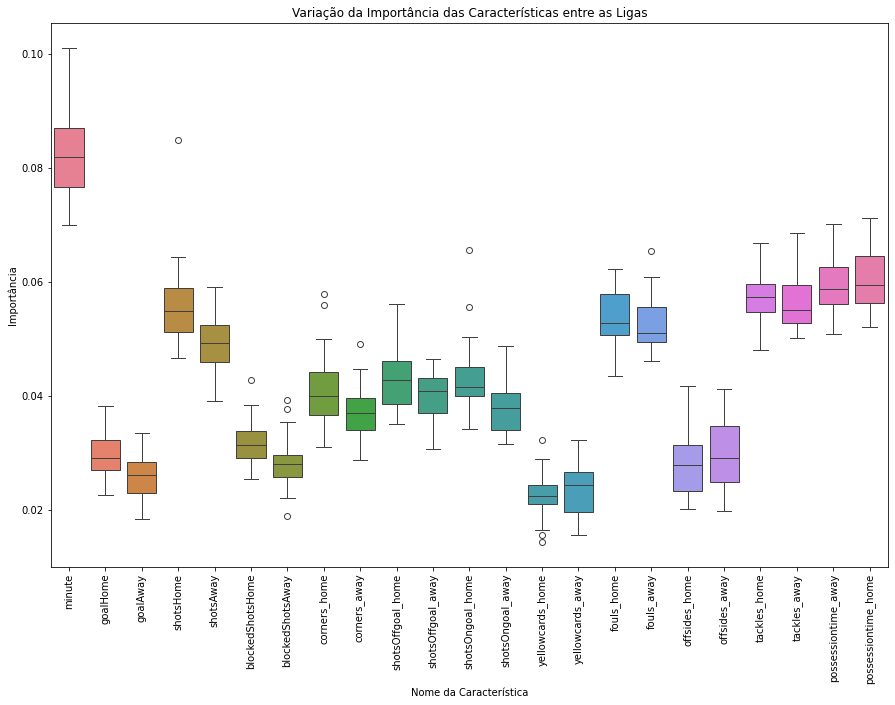

In [10]:
low_importance_features_indices = summary_df[summary_df['Mean Importance'] <= 0.014532]['Feature'].tolist()
# low_importance_features_indices2 = summary_df[summary_df['Variance'] >= 0.000016]['Feature'].tolist()
# low_importance_features_indices = low_importance_features_indices1 + low_importance_features_indices2

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


# Engenharia de recursos

Em 'A League-Wide Evaluation of Factors Influencing Match Activity Profile in Elite Australian Football', Esmaeili, Clifton e Aughey (2020) destacam a complexidade e a multifatorialidade do desempenho em jogos de futebol de elite. As medidas de desempenho utilizadas para o sistema de análise de partidas 'Champdas Master System' foram divididas em 
- Desempenho relacionado ao ataque
- Desempenho relacionado com passes
- Desempenho relacionado com Defesa

Nos dados, as estatisticas,
- de ataque são: shotsOngoal, shotsOffGoal, corners
- relacionada a passes: possessiontime
- relacionado a defesa: tackles, blockedShots

Anotações: Essas variáveis do artigo foram utilizadas para interpretar o impacto com os proprios dados do jogo. O trabalho presente avalia essas características como variáveis preditoras

In [12]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')
# Desempenho Relacionado ao Ataque
df['shotsOnGoalEfficiency'] = round((df['shotsOngoal_home'] + df['shotsOngoal_away']) / (df['shotsHome'] + df['shotsAway'] + 1), 2) # A eficiência do ataque em termos de chutes que realmente vão em direção ao gol.
df['attackPressure'] = round((df['shotsHome'] + df['shotsAway'] + df['corners_home'] + df['corners_away']) / df['minute'], 2) # Uma medida de quão ofensivas as equipes estão ao longo do jogo.
df['shotAccuracy_home'] = round(df['shotsOngoal_home'] / (df['shotsHome'] + 1), 2) # Proporção de chutes no gol em relação ao total de chutes.
df['shotAccuracy_away'] = round(df['shotsOngoal_away'] / (df['shotsAway'] + 1), 2)
# 1. Mudança na Frequência de Chutes a cada 10 minutos
df['shotsHome_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['shotsHome'].transform('sum')
df['shotsAway_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['shotsAway'].transform('sum')
# Desempenho Relacionado com Gols
df['goalMinute_Home'] = df['minute'].where(df['goalHome'].diff().fillna(0) > 0)
df['goalMinute_Away'] = df['minute'].where(df['goalAway'].diff().fillna(0) > 0)
df['timeSinceLastEvent_Home'] = df['minute'] - df.groupby(df['goalMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEvent_Away'] = df['minute'] - df.groupby(df['goalMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho relacionado com chutes 
df['shotsMinute_Home'] = df['minute'].where(df['shotsHome'].diff().fillna(0) > 0)
df['shotsMinute_Away'] = df['minute'].where(df['shotsAway'].diff().fillna(0) > 0)
df['timeSinceLastEventShots_Home'] = df['minute'] - df.groupby(df['shotsMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventShots_Away'] = df['minute'] - df.groupby(df['shotsMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho Relacionado com Passes
df['possessionControl'] = abs(df['possessiontime_home'] - df['possessiontime_away']) # Diferença absoluta do tempo de posse entre as equipes, indicando qual equipe dominou a posse de bola.
# df['passRisk'] = (df['offsides_home'] + df['offsides_away']) / (df['possessiontime_home'] + df['possessiontime_away']) # Indicativo de quão arriscados são os passes, resultando em impedimentos.
df['passRiskHome'] = df['offsides_home'] / (df['possessiontime_home']+ 0.01)
df['passRiskAway'] = df['offsides_away'] / (df['possessiontime_away']+ 0.01)
# 1. Mudança na Frequência de Posse a cada 10 minutos
df['passesHome_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['possessiontime_home'].transform('sum')
df['passesAway_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['possessiontime_away'].transform('sum')
# Desempenho relacionado com passes
df['passesMinute_Home'] = df['minute'].where(df['possessiontime_home'].diff().fillna(0) > 0)
df['passesMinute_Away'] = df['minute'].where(df['possessiontime_away'].diff().fillna(0) > 0)
df['timeSinceLastEventPasses_Home'] = df['minute'] - df.groupby(df['passesMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventPasses_Away'] = df['minute'] - df.groupby(df['passesMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho Relacionado com Defesa
df['TotalCards_home'] = df['redcards_home'] + df['yellowcards_home']
df['TotalCards_away'] = df['redcards_away'] + df['yellowcards_away']

df['defensiveDiscipline'] = round((1 - (df['redcards_home'] + df['yellowcards_home'] + df['fouls_home'] + 
                                   df['redcards_away'] + df['yellowcards_away'] + df['fouls_away']) / df['minute']), 2) # Uma medida de quão disciplinadas as equipes estão em termos de cartões e faltas.

df['defensiveEfficacy'] = round((df['blockedShotsHome'] + df['blockedShotsAway']) / round((df['shotsOnGoalEfficiency'] + 1), 2), 2) # Avalia a habilidade da defesa de bloquear chutes eficientes.
df['defensiveAggression'] = round((df['tackles_home'] + df['tackles_away']) / df['minute'], 2) # Indicativo de quão agressiva a equipe é na defesa ao longo do jogo.
# 1. Mudança na Frequência de Chutes Bloqueados a cada 10 minutos
df['blockedShotsHome_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['blockedShotsHome'].transform('sum')
df['blockedShotsAway_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['blockedShotsAway'].transform('sum')
# 2. Mudança na Frequência de Faltas a cada 10 minutos
df['foulsHome_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['fouls_home'].transform('sum')
df['foulsAway_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['fouls_away'].transform('sum')
# 3. Mudança na Frequência de Cartões a cada 10 minutos
df['TotalCardsHome_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['TotalCards_home'].transform('sum')
df['TotalCardsAway_10min'] = df.groupby(pd.cut(df['minute'], range(0, 91, 10)))['TotalCards_away'].transform('sum')
# Desempenho relacionado com faltas
df['foulsMinute_Home'] = df['minute'].where(df['fouls_home'].diff().fillna(0) > 0)
df['foulsMinute_Away'] = df['minute'].where(df['fouls_away'].diff().fillna(0) > 0)
df['timeSinceLastEventFouls_Home'] = df['minute'] - df.groupby(df['foulsMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventFouls_Away'] = df['minute'] - df.groupby(df['foulsMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho relacionado com cartões
df['TotalCardsMinute_Home'] = df['minute'].where(df['TotalCards_home'].diff().fillna(0) > 0)
df['TotalCardsMinute_Away'] = df['minute'].where(df['TotalCards_away'].diff().fillna(0) > 0)
df['timeSinceLastEventTotalCards_Home'] = df['minute'] - df.groupby(df['TotalCardsMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventTotalCards_Away'] = df['minute'] - df.groupby(df['TotalCardsMinute_Away'].notnull().cumsum())['minute'].transform('first')








# agora posso excluir características com baixa importância
# low_importance_features = summary_df[summary_df['Mean Importance'] < 0.0141032]['Feature Name'].tolist()
# print("Características com baixa importância:\n", low_importance_features)

# # Removendo as características com baixa importância
# df.drop(columns=low_importance_features, inplace=True)

# Visualizar o DataFrame com as novas features
df.head()


,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,TotalCardsHome_10min,TotalCardsAway_10min,foulsMinute_Home,foulsMinute_Away,timeSinceLastEventFouls_Home,timeSinceLastEventFouls_Away,TotalCardsMinute_Home,TotalCardsMinute_Away,timeSinceLastEventTotalCards_Home,timeSinceLastEventTotalCards_Away
0,1,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,2246.0,2427.0,NaN,NaN,0,0,NaN,NaN,0,0
1,2,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,2246.0,2427.0,NaN,NaN,1,1,NaN,NaN,1,1
2,3,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,2246.0,2427.0,NaN,NaN,2,2,NaN,NaN,2,2
3,4,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,2246.0,2427.0,NaN,NaN,3,3,NaN,NaN,3,3
4,5,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,2246.0,2427.0,NaN,NaN,4,4,NaN,NaN,4,4


In [15]:
df.drop(columns=['goalMinute_Home', 'goalMinute_Away', 'shotsMinute_Home', 'shotsMinute_Away', 'passesMinute_Home', 'passesMinute_Away', 'foulsMinute_Home', 'foulsMinute_Away', 'TotalCardsMinute_Home', 'TotalCardsMinute_Away'], inplace=True)

In [16]:
df.head()

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,blockedShotsHome_10min,blockedShotsAway_10min,foulsHome_10min,foulsAway_10min,TotalCardsHome_10min,TotalCardsAway_10min,timeSinceLastEventFouls_Home,timeSinceLastEventFouls_Away,timeSinceLastEventTotalCards_Home,timeSinceLastEventTotalCards_Away
0,1,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,11123.0,9282.0,50438.0,49650.0,2246.0,2427.0,0,0,0,0
1,2,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,11123.0,9282.0,50438.0,49650.0,2246.0,2427.0,1,1,1,1
2,3,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,11123.0,9282.0,50438.0,49650.0,2246.0,2427.0,2,2,2,2
3,4,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,11123.0,9282.0,50438.0,49650.0,2246.0,2427.0,3,3,3,3
4,5,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,11123.0,9282.0,50438.0,49650.0,2246.0,2427.0,4,4,4,4


In [14]:
df.isnull().sum().sum()

5762574

In [49]:
# Verificar a presença de valores infinitos
# print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# # Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # substituído pelo último valor não-NaN anterior na coluna.
# df.fillna(method='ffill', inplace=True)

In [50]:
df.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")